In [ ]:
import requests
from bs4 import BeautifulSoup
from astropy.io import fits
import matplotlib.pyplot as plt
from desispec.io.spectra import read_spectra
import numpy as np
from desitarget.targetmask import desi_mask
import pandas as pd


In [ ]:
r_i = requests.get("https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/") 
soup_i = BeautifulSoup(r_i.content, "html.parser")
all_links_i = soup_i.find_all("a")
linkList_i = [link['href'] for link in all_links_i[1:]] # creates a list of all the first indicies of the coaad files

all_lists = []
for i in range(len(linkList_i)):
    r_j = requests.get("https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/" + str(linkList_i[i]))
    soup_j = BeautifulSoup(r_j.content, "html.parser")
    all_links_j = soup_j.find_all("a")
    linkList_j = [link['href'] for link in all_links_j] 
    all_lists.append(linkList_j[1:]) # creates a list of all the second indicies of the coaad files for each of the first indicies

In [70]:
hdul = fits.open("qso_cat_dr1_main_dark_healpix_zlya-v0.fits") # lya quasar catalog
data = hdul[1].data
flux_b = []; flux_r = []; flux_z = [] # Initialize lists
wave_b = []; wave_r = []; wave_z = []
ivar_b = []; ivar_r = []; ivar_z = []
zArray = []
tidArray = []
for i in range(1): #range(len(linkList_i))
    for j in range(2): #range(len(all_lists[i]))
        r = requests.get("https://data.desi.lbl.gov/public/dr1/spectro/redux/iron/healpix/main/dark/" +  str(linkList_i[i]) # uses url generated from linkList and all_lists
                     + str(all_lists[i][j]) + "coadd-main-dark-"+  str(all_lists[i][j]).replace("/","") + ".fits")
        print(r.status_code)
        with open("coadd-main-dark-" + str(all_lists[i][j]).replace("/","") + ".fits", "wb") as fp: #dowloads the file with the name generated from all_lists
            fp.write(r.content)
            
        spec = read_spectra("coadd-main-dark-" + str(all_lists[i][j]).replace("/","") + ".fits" ) # gets spectra data from the coaad file
        fibermap = spec.fibermap
        coadd_dict = {tid: ii for ii, tid in enumerate(fibermap["TARGETID"])} # creates a dictionary of indicies with the target id as the key
        validQSOidx = []
        for ii, tid in enumerate(data["TARGETID"]):
            if (data["Z"][ii] > 2) and (data["ZWARN"][ii] == 0) and (data["BI_CIV"][ii] == 0): #checks that Z > Z_min, ZWARN = 0, and BI_CIV > BI_CIV_min
                if tid in coadd_dict: # checks that the target id from the lya QSO catelog is in the coadd file
                    validQSOidx.append(coadd_dict[tid]) # generates a list of indicies of valid QSOs
                    tidArray.append(tid) #generates a list of target id's of valis QSOs
                    zArray.append(data["Z"][ii]) # generates a list of redshift of all the valid QSOs
                    wave_b.append(spec.wave['b']/(1+data["Z"][ii])) # appends an array of the range of wavelgenths in the rest frame for each arm
                    wave_r.append(spec.wave['r']/(1+data["Z"][ii]))
                    wave_z.append(spec.wave['z']/(1+data["Z"][ii]))
        flux_b.extend(spec.flux['b'][validQSOidx]); flux_r.extend(spec.flux['r'][validQSOidx]); flux_z.extend(spec.flux['z'][validQSOidx]) # appends an array of the flux and ivar for each arm for all the valid QSOs
        ivar_b.extend(spec.ivar['b'][validQSOidx]); ivar_r.extend(spec.ivar['r'][validQSOidx]); ivar_z.extend(spec.ivar['z'][validQSOidx])
    
        filename = "coadd-main-dark-" + str(all_lists[i][j]).replace("/", "") + ".fits"
        !rm -rf "{filename}" # removes the downloaded coadd file


200
INFO:spectra.py:451:read_spectra: iotime 2.064 sec to read spectra from:  coadd-main-dark-0.fits at 2025-06-24T12:25:04.395333
200
INFO:spectra.py:451:read_spectra: iotime 2.014 sec to read spectra from:  coadd-main-dark-1.fits at 2025-06-24T12:28:43.010998


In [ ]:
np.savez('validQSOData.npz', 
         TARGETID=tidArray,
         Z=zArray,
         FLUX_B=flux_b,
         FLUX_R=flux_r,
         FLUX_Z=flux_z,
         WAVE_B=wave_b,
         WAVE_R=wave_r,
         WAVE_Z=wave_z,
         IVAR_B=ivar_b,
         IVAR_R=ivar_r,
         IVAR_Z=ivar_z)
#data = np.load('validQSOData.npz')


In [ ]:
finalData = {'TARGETID': tidArray,
             'Z': zArray,
             'FLUX_B': flux_b,
             'FLUX_R': flux_r,
             'FLUX_Z': flux_z,
             'WAVE_B': wave_b,
             'WAVE_R': wave_r,
             'WAVE_Z': wave_z,
             'IVAR_B': ivar_b,
             'IVAR_R': ivar_r,
             'IVAR_Z': ivar_z,    
}

df = pd.DataFrame(finalData)

df.to_csv('validQSOData.csv', columns=['TARGETID','Z','FLUX_B','FLUX_R','FLUX_Z','WAVE_B','WAVE_R','WAVE_Z', 
                                       'IVAR_B','IVAR_R','IVAR_Z'], index=False) # writes all the data to a csv

/tmp/ipykernel_29729/3868799902.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


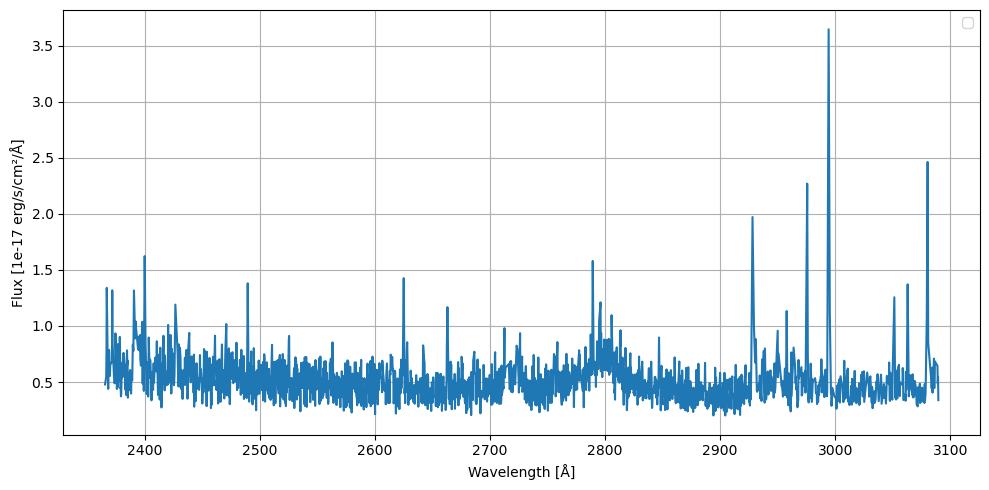

In [55]:
flux = flux_z[0]
ivar = ivar_z[0]
wave = wave_z[0]

good = flux*np.sqrt(ivar)>2
wave = wave[good]
flux = flux[good]

plt.figure(figsize=(10, 5))
plt.plot(wave, flux)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [1e-17 erg/s/cm²/Å]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()